In [1]:
import os
import sys
sys.path.append(os.path.abspath('../src'))

import json
import yaml
import spyt
import scipy
import warnings
import numpy as np
import pandas as pd
import typing as tp
from itertools import product
import matplotlib.pyplot as plt
import pyspark.sql.types as T
import pyspark.sql.functions as F
from pathlib import Path
from scipy.stats import norm

from pyspark.sql.window import Window
from pyspark.sql.functions import col, lit
from datetime import datetime, timedelta
from tqdm.notebook import tqdm

from sklearn.base import TransformerMixin

from clan_tools.utils.spark import SPARK_CONF_SMALL, safe_append_spark
from clan_tools.data_adapters.YTAdapter import YTAdapter
from clan_tools.data_adapters.YQLAdapter import YQLAdapter

from pyspark.sql.column import Column as SparkColumn


os.environ['NUMEXPR_MAX_THREADS'] = '32'
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 250)

In [2]:
from clan_tools.secrets.Vault import Vault

vault_client = Vault()
vault_client.get_secrets(secret_name='pavelvasilev')
# robot-clanalytics-yt, robot-clan-pii-yt, pavelvasilev

yql_adapter = YQLAdapter()
yt_adapter = YTAdapter()


spark = spyt.connect(spark_conf_args=SPARK_CONF_SMALL)
spyt.info(spark)

2022-05-23 12:51:20,013 - INFO - spyt.client - SPYT Cluster version: 1.36.0
2022-05-23 12:51:20,015 - INFO - spyt.client - SPYT library version: 1.36.0
2022-05-23 12:51:20,118 - INFO - spyt.client - SHS link: http://sas6-1213-tablet-node-hahn.sas.yp-c.yandex.net:27001/history/app-20220523125118-0260/jobs/


In [3]:
import statsmodels.api as sm

from clan_tools.utils.time import parse_date
from clan_tools.utils.time import DATE_FORMAT
from support_tickets_forecast.data import linear_fix_ts
from support_tickets_forecast.data import TicketsDataset
from support_tickets_forecast.time_features import safe_resample_weekly
from support_tickets_forecast.time_features import get_date_sin_cos_features_weekly
from support_tickets_forecast.time_features import DAYS_OF_WEEK_REV

In [12]:
ticket_dataset = TicketsDataset(spark, yt_adapter)
df_target = ticket_dataset.get_y()
df_target = df_target[df_target['components_quotas'] == False]  # noqa: E712
df_target = df_target['count'].resample('1D').sum().fillna(0)

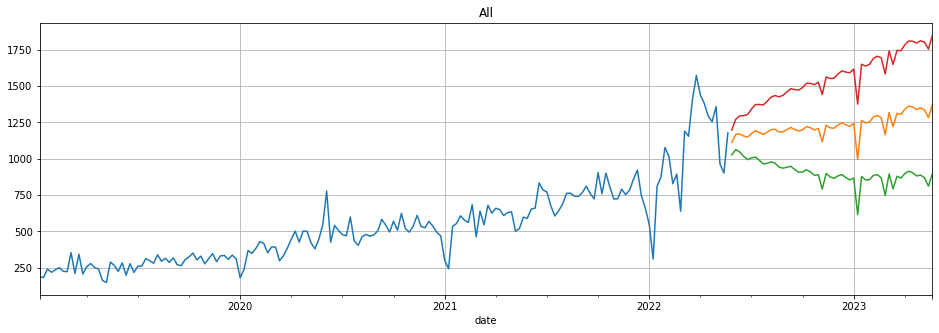

In [55]:
ci = 0.7
target = df_target.copy()

dt_from, dt_to = target.index.min().strftime('%Y-%m-%d'), target.index.max().strftime('%Y-%m-%d')
sampling = 'W-'+DAYS_OF_WEEK_REV[target.index.max().weekday()]
target = safe_resample_weekly(target, sampling)

dt_from, dt_to = ((target.index.min() - timedelta(days=6)).strftime('%Y-%m-%d'), target.index.max().strftime('%Y-%m-%d'))

exog_curr = get_date_sin_cos_features_weekly(dt_from, dt_to, 0)
to_date = target.index.max() + timedelta(weeks=52)
exog_fut = get_date_sin_cos_features_weekly(dt_to, to_date.strftime('%Y-%m-%d'), 0)


model = sm.tsa.SARIMAX(linear_fix_ts(target, '2022-03-10', '2022-05-01'),
                       exog=exog_curr, order=(1, 1, 0), trend='c').fit(maxiter=300)
pred = model.get_forecast(to_date, exog=exog_fut).summary_frame()
pred['mean_ci_lower'] = np.maximum(pred['mean_ci_lower'], 0)

n_std = (norm.ppf(1-(1-ci)/2)-norm.ppf((1-ci)/2))/2
pred['mean_ci_lower'] = pred['mean'] - n_std * pred['mean_se']
pred['mean_ci_upper'] = pred['mean'] + n_std * pred['mean_se']

fig, ax = plt.subplots(figsize=(16, 5))
target.plot(ax=ax)
plt.title('All')

pred['mean'].plot(ax=ax)
pred['mean_ci_lower'].plot(ax=ax)
pred['mean_ci_upper'].plot(ax=ax)

plt.grid()
plt.show()